In [47]:
#imports
import requests
import json
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
from datetime import datetime
import time as clock

start_time = clock.time()
# Sensors_Data = pd.read_json('data/W512_readings.json')
# Aircon_Data = pd.read_json('data/W512_aircon_status.json')
# Weather_Data = pd.read_json('data/Weather_data.json')

Sensors_Data = pd.read_json('../test/W512_readings1.json')
Aircon_Data = pd.read_json('../test/W512_aircon_status1.json')
Weather_Data = pd.read_json('../test/Weather_data1.json')
# Aircon_Data = Aircon_Data.iloc[3194:] #testing out new dataset (data is cleaned before pulling)
# Normalize the data
Aircon_rows = []

for _, row in Aircon_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    fc_readings = row['FC_FullStatus_Readings']
    if fc_readings and isinstance(fc_readings, dict):
        for unit, data in fc_readings.items():
            if any(data.get("Set_Point", None) == 404.0 for data in fc_readings.values()):
                continue
            flattened_row[f"{unit}_Status"] = data.get("Status", None)
            flattened_row[f"{unit}_Fan_Status"] = data.get("Fan_Status", None)
            flattened_row[f"{unit}_Set_Point"] = data.get("Set_Point", None)
            flattened_row[f"{unit}_Operation_Mode"] = data.get("Operation_Mode", None)
    
    Aircon_rows.append(flattened_row)

Sensors_rows = []
include_keys_1 = ["24E124725E285123", "24E124725E331695","24E124725E331744",
                      "24E124725E332483","24E124725E290348","24E124725E331733","24E124725E286745","24E124725E332564" # "24E124136D316361" is supposed to be outdoor but it is not outdoor yet
                         "24E124757E150866","24E124757E150896"]

include_keys_2 = ["Sensor_1","Sensor_3","Sensor_6"]
for _, row in Sensors_Data.iterrows():
    invalid_input = False
    
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    
    lorawan_readings = row['Lorawan_Readings']
    
    if isinstance(lorawan_readings, dict):
        for unit, data in lorawan_readings.items():
            if unit not in include_keys_1:
                continue
            if isinstance(data, dict):  # Ensure that each item in Lorawan_Readings is a dictionary
                for key, value in data.items():
                    
                    flattened_row[f"{unit}_{key}"] = value
            
    energy_readings = row['Energy_Readings']
    total_power = 0
    total_energy = 0
    invalid_input_power = False
    invalid_input_energy = False
    
    if energy_readings and isinstance(energy_readings, dict):
        for unit, data in energy_readings.items():
            if unit not in include_keys_2:
                continue
            power = data.get('Power', None)
            energy = data.get('Energy', None)
            if power is None:
                invalid_input_power = True
            if energy is None:
                invalid_input_energy = True
            total_power += power
            total_energy += energy
        
    if invalid_input_power:
        total_power = None
    if invalid_input_energy:
        total_energy = None
        
    flattened_row["Total_Energy"] = total_energy
    flattened_row["Total_Power"] = total_power
    
    Sensors_rows.append(flattened_row)


# Normalize the data
Weather_rows = []

for _, row in Weather_Data.iterrows():
    date = row['date']
    time = row['time']
    
    flattened_row = {
        "date": date,
        "time": time
    }
    
    flattened_row['weather_status']= row['result']['weather_status']
    flattened_row['weather_temp']= row['result']['weather_temp']
    flattened_row['weather_humidity']= row['result']['weather_humidity']
    
    Weather_rows.append(flattened_row)



Aircon_Normalize_Data = pd.DataFrame(Aircon_rows)
Sensors_Normalize_Data = pd.DataFrame(Sensors_rows)
Weather_Normalize_Data = pd.DataFrame(Weather_rows)
# For Aircon_Normalize_Data
Aircon_Normalize_Data['datetime_str'] = Aircon_Normalize_Data['date'].astype(str) + ' ' + Aircon_Normalize_Data['time']
Aircon_Normalize_Data['datetime'] = Aircon_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Aircon_Normalize_Data['timestamp'] = Aircon_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Sensors_Normalize_Data
Sensors_Normalize_Data['datetime_str'] = Sensors_Normalize_Data['date'].astype(str) + ' ' + Sensors_Normalize_Data['time']
Sensors_Normalize_Data['datetime'] = Sensors_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Sensors_Normalize_Data['timestamp'] = Sensors_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

# For Weather_Normalize_Data
Weather_Normalize_Data['datetime_str'] = Weather_Normalize_Data['date'].astype(str) + ' ' + Weather_Normalize_Data['time']
Weather_Normalize_Data['datetime'] = Weather_Normalize_Data['datetime_str'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %I:%M:%S %p"))
Weather_Normalize_Data['timestamp'] = Weather_Normalize_Data['datetime'].apply(lambda x: int(x.timestamp()))

merged_data = pd.merge_asof(
    Aircon_Normalize_Data,  # Left DataFrame
    Sensors_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)
merged_data = pd.merge_asof(
    merged_data,  # Left DataFrame
    Weather_Normalize_Data,      # Right DataFrame
    on='timestamp',   # Key column
    direction='nearest'    # Match the nearest time
)

temperature_col = [
    col for col in merged_data.columns 
    if "temperature" in col.lower()
]
humidity_col = [
    col for col in merged_data.columns 
    if "humidity" in col.lower()
]
c02_col = [
    col for col in merged_data.columns
    if "co2" in col.lower()
]

occupancy_col_total_in = [
    col for col in merged_data.columns
    if "total_in" in col.lower()
]

occupancy_col_total_out = [
    col for col in merged_data.columns
    if "total_out" in col.lower()
]

def get_unit_columns(unit_number, columns):
    return [col for col in columns if f"FC_Unit_{unit_number}" in col]

aircon_units = len([
    col for col in merged_data.columns
    if "FC_Unit_" in col and "_Status" in col and "Fan" not in col
])

aircon_units_cols = {}

for unit in range(1, aircon_units + 1):
    aircon_units_cols[f'Unit_{unit}'] = get_unit_columns(unit, merged_data.columns)


final_data = pd.DataFrame()
final_data["timestamp"] = merged_data["timestamp"]

final_data["temperature"] = merged_data[temperature_col].apply(lambda x: round(x.mean(), 3), axis=1)
final_data["humidity"] = merged_data[humidity_col].apply(lambda x: round(x.mean(),3), axis=1)
final_data["co2"] = merged_data[c02_col].apply(lambda x: round(x.mean(),3), axis=1)

final_data['power_consumption'] = merged_data['Total_Power']
final_data['energy_consumption'] = merged_data['Total_Energy']

final_data["weather_status"] = merged_data["weather_status"]
final_data["weather_temp"] = merged_data['weather_temp']
final_data["weather_humid"] = merged_data['weather_humidity']


merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')

final_data['occupancy'] = (
    merged_data[occupancy_col_total_in].sum(axis=1) - merged_data[occupancy_col_total_out].sum(axis=1)
)


for unit, columns in aircon_units_cols.items():
    for column in columns:
        if 'set_point' in column:
            final_data[column] = merged_data[column].replace(0, pd.NA).ffill()
        else:
            final_data[column] = merged_data[column].replace("ERROR", pd.NA).ffill()

final_data.dropna(inplace=True)
print("final_data_created")

# Sorting the data by energy_consumption in ascending order
final_data = final_data.sort_values(by="timestamp", ascending=True)
final_data.to_csv("test.csv", index=False)

# Creating a list to store the calculated differences
energy_consumption = []

# Loop through the data to calculate energy consumption differences
for i in range(len(final_data) - 1):
    x = final_data["timestamp"].iloc[i + 1] - final_data["timestamp"].iloc[i]
    diff = final_data["energy_consumption"].iloc[i + 1] - final_data["energy_consumption"].iloc[i]
    if x < 18000 and diff < 50 and diff > 0:
        energy_consumption.append(diff)
    else:
        
        energy_consumption.append(float('nan'))
        
energy_consumption.append(float('nan'))

# Assign the new energy_consumption values to the dataframe
final_data["energy_consumption"] = energy_consumption

# Drop rows with NaN values and update final_data
final_data = final_data.dropna()

# Optionally, you can save the updated dataframe
final_data.to_csv("updated_test.csv", index=False)




C:\Users\Ang Yun Yang\AppData\Local\Temp\ipykernel_20396\3005276204.py:207: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_in] = merged_data[occupancy_col_total_in].fillna(method='bfill')
C:\Users\Ang Yun Yang\AppData\Local\Temp\ipykernel_20396\3005276204.py:208: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[occupancy_col_total_out] = merged_data[occupancy_col_total_out].fillna(method='bfill')


final_data_created


['Rain' 'Clouds' 'Thunderstorm' 'Clear' 'Haze']


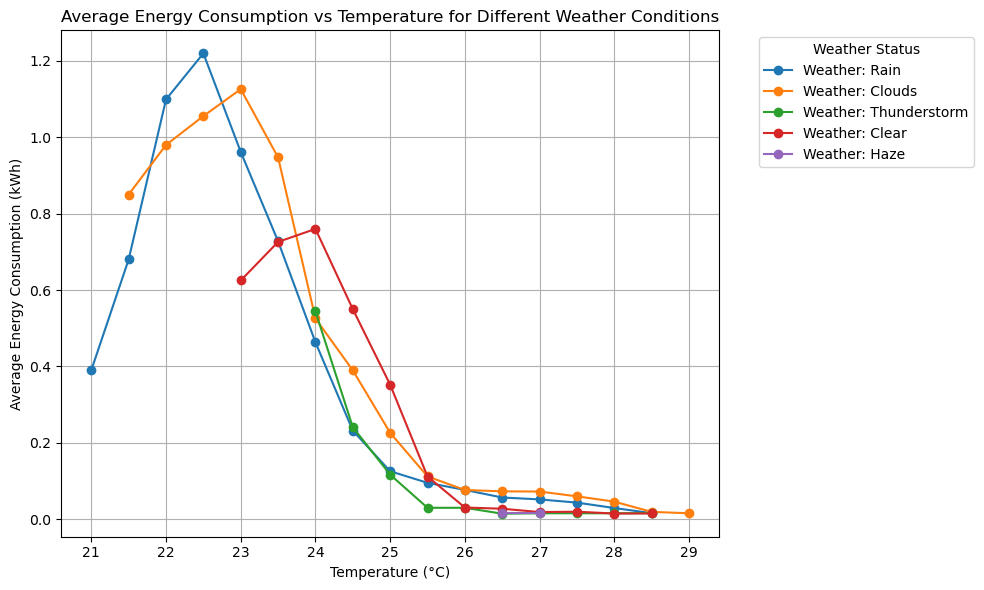

In [54]:
unique_weather_statuses = final_data["weather_status"].unique()
print(unique_weather_statuses)
# Temperature range for 20 to 29
temperature_values = np.around(np.arange(20, 30.5, 0.5), decimals=1)

# Initialize a plot
plt.figure(figsize=(10, 6))

# Loop through each unique weather status
for status in unique_weather_statuses:
    weather_data = final_data[final_data["weather_status"] == status]
    
    # List to store average energy consumption for each temperature value
    avg_energy_consumption = []

    # Loop through temperature values and calculate average energy consumption
    for temp in temperature_values:
        # Filter the data for temperatures in the range ±0.5°C of the current temperature value
        temp_data = weather_data[(weather_data['temperature'] >= (temp - 0.5)) & 
                                 (weather_data['temperature'] <= (temp + 0.5))]

        # If data exists for this temperature, calculate average energy consumption
        if not temp_data.empty:
            avg_energy = temp_data['energy_consumption'].mean()
            avg_energy_consumption.append(avg_energy)
        else:
            avg_energy_consumption.append(np.nan)  # No data, add NaN

    # Plot the data for the current weather status
    plt.plot(temperature_values, avg_energy_consumption, label=f"Weather: {status}", marker='o')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('Average Energy Consumption (kWh)')
plt.title('Average Energy Consumption vs Temperature for Different Weather Conditions')

# Add grid and legend
plt.grid(True)
plt.legend(title='Weather Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [57]:
import seaborn as sns

# Temperature range for 20 to 29 with ±0.5 intervals
temperature_values = np.around(np.arange(20, 30.5, 0.5), decimals=1)

# Create a new column for temperature bins
final_data['temperature_bin'] = pd.cut(
    final_data['temperature'], 
    bins=[temp - 0.5 for temp in temperature_values] + [30],  # Create bins for the range
    labels=temperature_values[:-1],  # Assign labels to bins
    right=False  # Make bins inclusive of the left edge
)

# Initialize a figure
plt.figure(figsize=(12, 8))

# Create a boxplot for energy consumption vs temperature_bin, grouped by weather status
sns.boxplot(
    data=final_data,
    x='temperature_bin', 
    y='energy_consumption', 
    hue='weather_status',
    palette='Set2'
)

# Add labels and title
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.title('Energy Consumption Distribution by Temperature Interval and Weather Status', fontsize=14)

# Adjust legend and layout
plt.legend(title='Weather Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


ValueError: Bin labels must be one fewer than the number of bin edges